# Ligand-based Target Prediction example
## George Papadatos, ChEMBL Group

This is a short demo on getting target predictions based on the current multi-category Naive Bayesian ChEMBL_21 models for a single molecule input. The predictions are ranked by the output classifier probability.

This is the outline of the demo:

* Download the models
* Input a molecule to get target predictions for it based on the models
* Assess the predictions

### 1) Download the models (this is needed only once)

In [14]:
cd testmodels_21/

/Users/georgep/testmodels_21


In [1]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/chembl/target_predictions/chembl_21_models.tar.gz

--2016-03-29 15:16:53--  ftp://ftp.ebi.ac.uk/pub/databases/chembl/target_predictions/chembl_21_models.tar.gz
           => 'chembl_21_models.tar.gz'
Resolving ftp.ebi.ac.uk... 193.62.194.182
Connecting to ftp.ebi.ac.uk|193.62.194.182|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/chembl/target_predictions ... done.
==> SIZE chembl_21_models.tar.gz ... 64469262
==> PASV ... done.    ==> RETR chembl_21_models.tar.gz ... done.
Length: 64469262 (61M) (unauthoritative)

100%[======================================>] 64,469,262  44.7MB/s   in 1.4s   

2016-03-29 15:16:55 (44.7 MB/s) - 'chembl_21_models.tar.gz' saved [64469262]



In [2]:
!tar -zxf chembl_21_models.tar.gz

The two models (1uM and 10uM, respectively) are now under ./models_21

### 2) Read the models and get predictions
Import the necessary modules:

In [15]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw

from rdkit import DataStructs

import pandas as pd
from pandas import concat

from collections import OrderedDict
import requests
import numpy

In [16]:
from sklearn.externals import joblib

In [17]:
# Check the RDKit version
from rdkit import rdBase
print rdBase.rdkitVersion

2015.09.2


In [18]:
%matplotlib inline

In [19]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 10,10

In [20]:
morgan_nb = joblib.load('./models_21/10uM/mNB_10uM_all.pkl')

In [21]:
classes = list(morgan_nb.targets)

In [22]:
len(classes)

1429

That means that this model contains trained data for 1429 different targets (categories).

### 3) Read a compound and get predictions

Let's use a molecule (GS-5759) found in this [publication](http://www.ncbi.nlm.nih.gov/pubmed/24513870). It is a novel compound (not in ChEMBL) reported to have dual activity against PDE4 and beta-2 adrenergic receptor.

In [43]:
smiles = 'O[C@@H](CNCCCC#CC1=CC=C(C=C1)NC(=O)C=1C=C(C=CC1)S(=O)(=O)C=1C=C2C(=C(C=NC2=C(C1)C)C(=O)N)NC1=CC(=CC=C1)OC)C1=C2C=CC(NC2=C(C=C1)O)=O'

In [45]:
mol = Chem.MolFromSmiles(smiles)

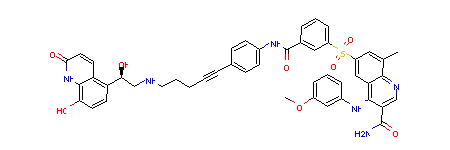

In [46]:
mol

In [47]:
info={}
fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048, bitInfo=info)
res = numpy.zeros(len(fp),numpy.int32)
DataStructs.ConvertToNumpyArray(fp,res)  

In [48]:
probas = list(morgan_nb.predict_proba(res.reshape(1,-1))[0])

In [49]:
predictions = pd.DataFrame(zip(classes, probas), columns=['id','proba'])

In [68]:
predictions.head(20)

,id,proba
0,CHEMBL1075051,7.053404e-33
1,CHEMBL1075104,4.911063e-17
2,CHEMBL1075108,4.848016e-38
3,CHEMBL1075111,2.056597e-40
4,CHEMBL1075115,7.705190e-10
5,CHEMBL1075138,6.682079e-07
6,CHEMBL1075140,5.666627e-41
7,CHEMBL1075145,2.389783e-36
8,CHEMBL1075152,4.561929e-42
9,CHEMBL1075167,8.753342e-09


The above is a pandas data frame with all the predictions across the 1429 targets.

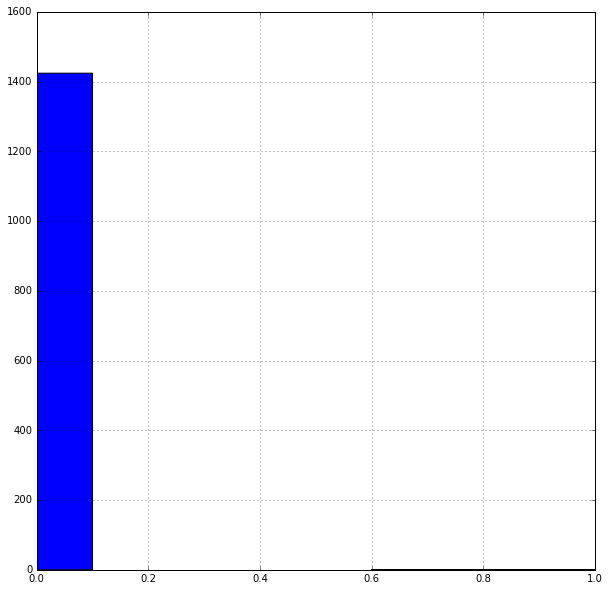

In [51]:
predictions['proba'].hist()

As expected, most of the targets will have very low probability for this particular compound. But what about the targets with the highest probability scores?

top_preds = predictions.sort_values(by='proba', ascending=False).head(10)

In [53]:
top_preds

,id,proba
1283,CHEMBL5414,0.999912
243,CHEMBL210,0.994003
652,CHEMBL3252,0.836839
249,CHEMBL213,0.747240
477,CHEMBL275,0.660680
1123,CHEMBL4697,0.000231
851,CHEMBL3864,0.000114
707,CHEMBL3397,0.000102
401,CHEMBL2535,0.000058
710,CHEMBL340,0.000031


Finally, let's use the ChEMBL WS to get some more info on the most likely predicted targets.

In [54]:
def fetch_WS(trgt):
    re = requests.get('https://www.ebi.ac.uk/chembl/api/data/target/{0}.json'.format(trgt))
    return (trgt, re.json()['pref_name'], re.json()['organism'])

In [55]:
plist = []
for i,e in enumerate(top_preds['id']):
    plist.append(fetch_WS(e))

In [56]:
target_info = pd.DataFrame(plist, columns =['id','name', 'organism'])

In [57]:
target_info

,id,name,organism
0,CHEMBL5414,Beta-2 adrenergic receptor,Cavia porcellus
1,CHEMBL210,Beta-2 adrenergic receptor,Homo sapiens
2,CHEMBL3252,Beta-1 adrenergic receptor,Rattus norvegicus
3,CHEMBL213,Beta-1 adrenergic receptor,Homo sapiens
4,CHEMBL275,Phosphodiesterase 4B,Homo sapiens
5,CHEMBL4697,Hexose transporter 1,Plasmodium falciparum
6,CHEMBL3864,Protein-tyrosine phosphatase 2C,Homo sapiens
7,CHEMBL3397,Cytochrome P450 2C9,Homo sapiens
8,CHEMBL2535,Glucose transporter,Homo sapiens
9,CHEMBL340,Cytochrome P450 3A4,Homo sapiens


In [58]:
pd.merge(top_preds, target_info)

,id,proba,name,organism
0,CHEMBL5414,0.999912,Beta-2 adrenergic receptor,Cavia porcellus
1,CHEMBL210,0.994003,Beta-2 adrenergic receptor,Homo sapiens
2,CHEMBL3252,0.836839,Beta-1 adrenergic receptor,Rattus norvegicus
3,CHEMBL213,0.747240,Beta-1 adrenergic receptor,Homo sapiens
4,CHEMBL275,0.660680,Phosphodiesterase 4B,Homo sapiens
5,CHEMBL4697,0.000231,Hexose transporter 1,Plasmodium falciparum
6,CHEMBL3864,0.000114,Protein-tyrosine phosphatase 2C,Homo sapiens
7,CHEMBL3397,0.000102,Cytochrome P450 2C9,Homo sapiens
8,CHEMBL2535,0.000058,Glucose transporter,Homo sapiens
9,CHEMBL340,0.000031,Cytochrome P450 3A4,Homo sapiens
